# Laboratorio de Datos 1ercuat 2022

## Clasificacion de Textos - Train

### Original - GUardar y Hacer Copia para trabajar - Estado al 30/05/2022

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from io import StringIO
import os
import re
import matplotlib.pyplot as plt
import pickle

from time import time

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import sklearn as sk

from collections import Counter

pd.set_option('display.max_columns', False)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

debug = True

limite_de_palabras = 20
out_path = os.getcwd() + '\\word_count_test' + '\\'
try:
    os.mkdir(out_path)
except:
    pass

In [2]:
df_clases = '002_Text_Classification_clases.csv'
id_clases_df = pd.read_csv(df_clases)[0:8]
id_clases_df.drop(columns=['clase'], inplace = True )
clase_a_id = dict(id_clases_df.values)
id_a_clase = dict(id_clases_df[['id_clase','clase_original']].values)

In [3]:
df_train_file = '002_Text_train_final_sin_numeros.csv'
df_a_procesar = pd.read_csv(df_train_file)
print(df_a_procesar.shape)
df_a_procesar.head(10)

(3709, 6)


,clase_original,texto_original,texto_etl,texto_corregido,id_clase,nro_palabras
0,no_identificada,se normalizo medidor lindero XXXXXXX estado XXXXX/XXXXX cambiando tapa y acometida.,normalizo medidor lindero estado cambiando tapa acometida,se normalizo medidor lindero estado cambiando tapa y acometida,7,7
1,ok_equipo,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa: XXXXX energia reactiva: XXXXXX,realizo verificacion completa coloco caja antihurto cambio pipeta rota energia activa energia reactiva,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa energia reactiva,6,13
2,intrusion,se corto conexion directa sin medidor. en pje XXX camino Y XXXX,corto conexion directo sin medidor pje camino Y,se corto conexion directa sin medidor en pje camino Y,0,8
3,no_identificada,se cambio medidor monofasico y normaliza.,cambio medidor monofasico normalizo,se cambio medidor monofasico y normaliza,7,4
4,intrusion,se retira conexion clandestina se normaliza suministro.,retira conexion clandestina normalizo suministro,se retira conexion clandestina se normaliza suministro,0,5
5,intrusion,numerador manipulado se cambia medidor.,numerador manipulado cambio medidor,numerador manipulado se cambia medidor,0,4
6,reparacion,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta.,cambio medidor monofasico golpeado con visor roto tapa monofasica obsoleta,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta,1,10
7,intrusion,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo.,medidor manipulado fase neutro invertidos fase ingresaba bornera neutro neutro bornera fase normalizo,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo,0,13
8,reparacion,se encontro medidor quemado en bornera. se normaliza colocando medidor numero XXXXXXX. se realiza inspeccion completa y se coloca tapa capilla chica. se dejo presintado.,encontro medidor quemado bornera normalizo colocando medidor numero realizo inspeccion completa coloca tapa capilla chica dejo presintado,se encontro medidor quemado en bornera se normaliza colocando medidor numero se realiza inspeccion completa y se coloca tapa capilla chica se dejo presintado,1,17
9,intrusion,Se Quitó Fraude Fase X Fase. Se Normalizó El Servicio. Se Realiza Acta De Fraude.,quito fraude fase fase normalizo servicio realizo acta fraude,se quito fraude fase por fase se normalizo el servicio se realiza acta de fraude,0,9


In [4]:
print('Control de valores nulos\n-------------------------')
print('clase_original\t', df_a_procesar['clase_original'].isnull().values.any())
print('texto_original\t',df_a_procesar['texto_original'].isnull().values.any())
print('texto_etl\t',df_a_procesar['texto_etl'].isnull().values.any())
print('texto_corregido\t',df_a_procesar['texto_corregido'].isnull().values.any())
print('id_clase\t',df_a_procesar['id_clase'].isnull().values.any())
print('nro_palabras\t',df_a_procesar['nro_palabras'].isnull().values.any())

Control de valores nulos
-------------------------
clase_original	 False
texto_original	 False
texto_etl	 False
texto_corregido	 False
id_clase	 False
nro_palabras	 False


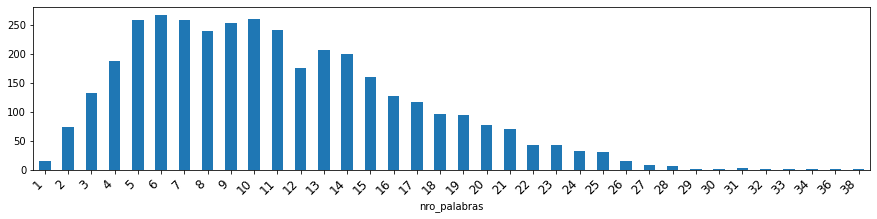

In [5]:
# Histograma del número de palabras
fig = plt.figure(figsize=(15,3))
df_a_procesar.groupby('nro_palabras').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show();

In [6]:
# Seleccion limitando la cantidad de palabras
df_a_procesar = df_a_procesar[df_a_procesar['nro_palabras']<=limite_de_palabras]
print(df_a_procesar.shape)

(3446, 6)


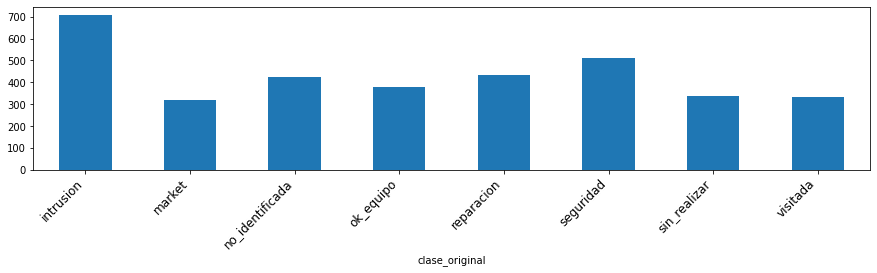

In [7]:
# Cantidad de textos por clase original
fig = plt.figure(figsize=(15,3))
aux = df_a_procesar.copy()
df_a_procesar.groupby('clase_original').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show()

In [8]:
df_a_procesar.groupby('clase_original').texto_original.count().sort_values(ascending=False) 

df_a_procesar['clase_original'].value_counts().to_csv(out_path + 'df_value_counts_nro_palabras_' + str(limite_de_palabras) + '.csv')

# Proceso con modelo tfidf

## Seleccion de caracteristicas

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 4)) #, stop_words=stop_words_spanish)
features = tfidf.fit_transform(df_a_procesar.texto_etl)
features = features.toarray()
labels = df_a_procesar.id_clase

pickle.dump(features, open('030_train_tfidf_features.pkl', 'wb'))
pickle.dump(features, open('030_train_tfidf.pkl', 'wb'))

In [10]:
print(df_a_procesar['texto_etl'].shape)
print(features.shape)
print(features[0])

(3446,)
(3446, 2322)
[0. 0. 0. ... 0. 0. 0.]


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

models = [
    #SVC(kernel = 'rbf', random_state = 0),
    #LinearSVC(),
    #LogisticRegression(),
    #MultinomialNB(),
    #SGDClassifier(),
    #CalibratedClassifierCV()
    #RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0),
    #GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=3, random_state=0)
]
CV = 20
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  print('begin with model' + model.__class__.__name__)
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  i = 0
  for fold_idx, accuracy in enumerate(accuracies):
    i += 1
    print('model' + model.__class__.__name__ + 'fold' + str(i))
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
bak = pd.read_csv('backup.csv', index_col=False).drop('Unnamed: 0', axis=1)
bak = pd.concat([bak, cv_df])

bak.groupby('model_name').mean()['accuracy']


bak['mean'] = [bak.groupby('model_name').mean()['accuracy'][x] for x in bak['model_name']]
bak['std'] = [bak.groupby('model_name').std()['accuracy'][x] for x in bak['model_name']]

bak.sort_values(by=['mean'], ascending=False, inplace=True)


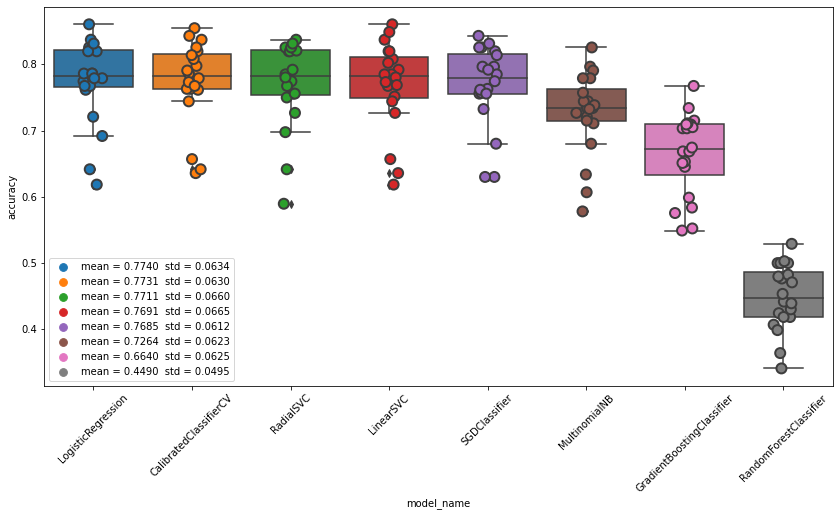

In [13]:
plt.figure(figsize=(12,6))

ax = sns.boxplot(x='model_name', y='accuracy', data=bak)
sns.stripplot(x='model_name', y='accuracy', hue = 'model_name', data=bak, size=10, jitter=True, edgecolor="gray", linewidth=2)

h, l = ax.get_legend_handles_labels()
labelss = []
for mean, std in zip(bak['mean'].unique(), bak['std'].unique()):
    labelss.append('mean = ' + "{:.4f}".format(mean) + '  std = ' + "{:.4f}".format(std))
ax.legend(h, labelss)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [14]:
f = open(out_path + 'model_accuracy.txt', 'w')
f.write(str(cv_df.groupby('model_name').accuracy.mean()))
f.write('\n')
f.write(str(cv_df.groupby('model_name').accuracy.std()))
f.close()

print(cv_df.groupby('model_name').accuracy.mean())
print(cv_df.groupby('model_name').accuracy.std())

Series([], Name: accuracy, dtype: object)
Series([], Name: accuracy, dtype: float64)



## Grid Search

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_a_procesar.index, test_size=0.25, random_state=0, stratify=df_a_procesar['id_clase'])

model_to_grid = LinearSVC()

print(X_train.shape)

(2584, 2322)


In [126]:
# Grid Search para LinearSVC
c_values = [0.2, 0.5, 0.7, 1, 1.3, 1.5, 2, 3, 5]
m_values = [5,10, 15, 20, 30, 50]

params = {'C': c_values, 'max_iter':m_values, 'loss': ['hinge']}
Grid_Search_LinearSVC = GridSearchCV(model_to_grid, params, scoring='accuracy', cv=25, verbose=10)
Grid_Search_LinearSVC.fit(X_train, y_train)


# Grid Search para Log reg
# params = {'C': [1, 5, 10, 15, 20], 'penalty': ['l2'], 'max_iter': [5,10,20,25,30,35,50, 75], 'class_weight' : [None]}
# Grid_Search_LinearSVC = GridSearchCV(model_to_grid, params, scoring='accuracy', cv=25, verbose = 10)
# Grid_Search_LinearSVC.fit(X_train, y_train)

Fitting 25 folds for each of 54 candidates, totalling 1350 fits
[CV 1/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 1/25; 1/54] END C=0.01, loss=hinge, max_iter=5;, score=0.721 total time=   0.0s
[CV 2/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 2/25; 1/54] END C=0.01, loss=hinge, max_iter=5;, score=0.683 total time=   0.0s
[CV 3/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 3/25; 1/54] END C=0.01, loss=hinge, max_iter=5;, score=0.731 total time=   0.0s
[CV 4/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 4/25; 1/54] END C=0.01, loss=hinge, max_iter=5;, score=0.779 total time=   0.0s
[CV 5/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 5/25; 1/54] END C=0.01, loss=hinge, max_iter=5;, score=0.740 total time=   0.0s
[CV 6/25; 1/54] START C=0.01, loss=hinge, max_iter=5............................
[CV 6/25; 1/54] END C=0.01, lo

GridSearchCV(cv=25, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 0.2, 0.5, 1, 3, 5, 7, 10],
                         'loss': ['hinge'],
                         'max_iter': [5, 10, 15, 20, 30, 50]},
             scoring='accuracy', verbose=10)

In [127]:
import math

print("Best parameters set found on development set:")
print()
print(Grid_Search_LinearSVC.best_params_)
print()
print("Grid scores on development set:")
print()
means = Grid_Search_LinearSVC.cv_results_["mean_test_score"]
stds = Grid_Search_LinearSVC.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, Grid_Search_LinearSVC.cv_results_["params"]):
#     if not math.isnan(mean):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print()

Best parameters set found on development set:

{'C': 1, 'loss': 'hinge', 'max_iter': 10}

Grid scores on development set:



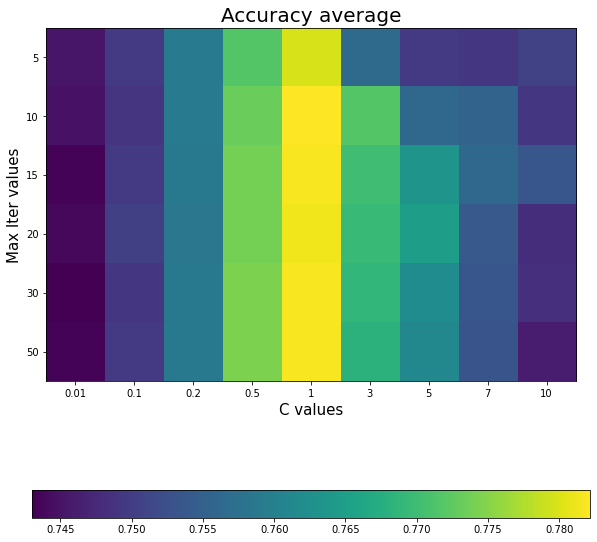

In [139]:
mean_BA_test = np.zeros((len(m_values),len(c_values)))
i=0

for yy,c in enumerate(c_values): # itero sobre c
    for xx,n in enumerate(m_values): # itero sobre n
        mean_BA_test[xx, yy] = means[i]
        i+=1

colormap = plt.cm.get_cmap('viridis') # 'plasma' or 'viridis'
#colors = colormap(scaled_z)
#sc = plt.scatter(x, y, c=colors)
#sm = plt.cm.ScalarMappable(cmap=colormap)
#sm.set_clim(vmin=0, vmax=100)

fig, ax = plt.subplots(figsize=(10,10)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test, cmap=colormap)

ax.set_xticks(range(0, len(c_values)), labels = c_values)
ax.set_xticklabels(c_values)
ax.set_yticks(range (0, len(m_values)), labels = m_values)
ax.set_yticklabels(m_values)
plt.xlabel('C values', fontsize=15)
plt.ylabel('Max Iter values', fontsize=15)
plt.title('Accuracy average', fontsize=20)


#plt.colorbar(sm)
#fig.colorbar(img, orientation="horizontal", pad=0.2)
fig.colorbar(img, orientation="horizontal", pad=0.2)

In [140]:
f = open(out_path + 'model_best_params.txt', 'w')
f.write(str(model_to_grid.get_params()))
f.write('\n')
f.write("El mejor score es:")
f.write(str(Grid_Search_LinearSVC.best_score_))
f.write('\n')
f.write("Los mejores parámetros son:")
f.write(str(Grid_Search_LinearSVC.best_params_))
f.close()

print("El mejor score es:")
print(Grid_Search_LinearSVC.best_score_)
print("Los mejores parámetros son:")
print(Grid_Search_LinearSVC.best_params_)

El mejor score es:
0.7821433905899926
Los mejores parámetros son:
{'C': 1, 'loss': 'hinge', 'max_iter': 10}


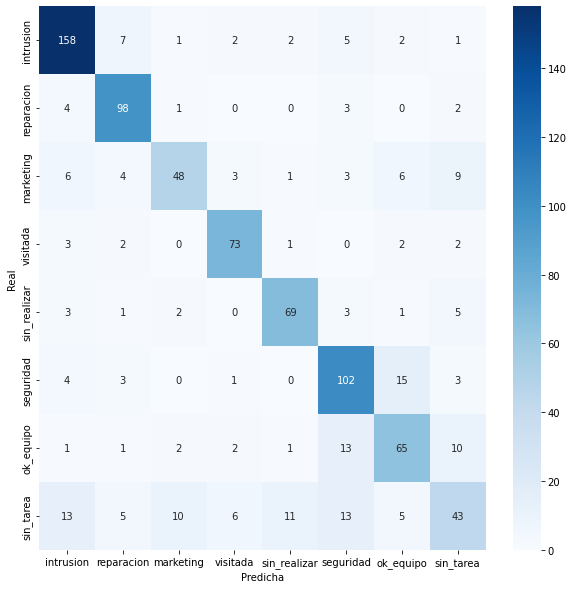

In [141]:
#model = SGDClassifier()
Best_Params_LinearSVC = Grid_Search_LinearSVC.best_estimator_
model = Best_Params_LinearSVC
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=0, stratify=df['category_id'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=id_clases_df['clase_original'].values, yticklabels=id_clases_df['clase_original'].values)
plt.ylabel('Real')
plt.xlabel('Predicha')
plt.savefig(out_path + 'heatmap.jpg')
plt.show()

In [142]:
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion.to_csv(out_path + '030_Text_matriz_confusion.csv', index=False)

In [143]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df_a_procesar['clase_original'].unique()))

                 precision    recall  f1-score   support

no_identificada       0.82      0.89      0.85       178
      ok_equipo       0.81      0.91      0.86       108
      intrusion       0.75      0.60      0.67        80
     reparacion       0.84      0.88      0.86        83
         market       0.81      0.82      0.82        84
      seguridad       0.72      0.80      0.76       128
       visitada       0.68      0.68      0.68        95
   sin_realizar       0.57      0.41      0.48       106

       accuracy                           0.76       862
      macro avg       0.75      0.75      0.75       862
   weighted avg       0.75      0.76      0.75       862



In [144]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(model) 
clf.fit(X_train, y_train)


key= '030_adv-Text_linear_svc_bp_prob.pkl'

pickle_byte_obj = pickle.dumps(clf)


In [145]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [146]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=model.predict(X_test), 
    y_score=clf.predict_proba(X_test))

print(report_with_auc)
report_with_auc.to_csv(out_path + 'report_with_auc.csv')

             precision    recall  f1-score  support   pred       AUC
0            0.822917   0.887640  0.854054  178.0    192.0  0.979434
1            0.809917   0.907407  0.855895  108.0    121.0  0.978547
2            0.750000   0.600000  0.666667  80.0     64.0   0.935566
3            0.839080   0.879518  0.858824  83.0     87.0   0.992530
4            0.811765   0.821429  0.816568  84.0     85.0   0.974691
5            0.718310   0.796875  0.755556  128.0    142.0  0.964306
6            0.677083   0.684211  0.680628  95.0     96.0   0.940355
7            0.573333   0.405660  0.475138  106.0    75.0   0.802155
avg / total  0.752694   0.761021  0.753366  862.0    862.0  0.958827


In [147]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from collections import defaultdict

def class_report_2(y_true, y_score):

    n_classes = len(y_true.unique())
    y = label_binarize(y_true.to_list(), classes = range(0, n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return (fpr, tpr, roc_auc)

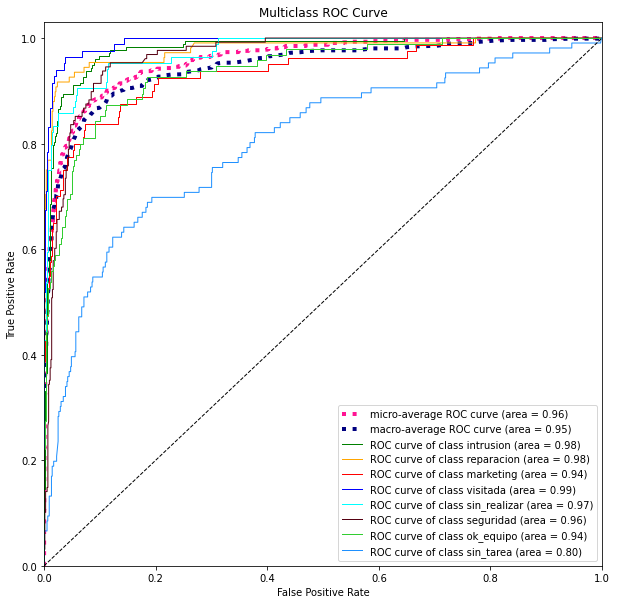

In [148]:
from itertools import cycle

fpr, tpr, roc_auc = class_report_2(y_test, clf.predict_proba(X_test))
lw = 1

plt.figure(figsize = (10,10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

n_classes = len(y_true.unique())
colors = ["green", "orange", 
         "red", "blue", "cyan", 
        "#550011", "limegreen",
         "dodgerblue"]

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(id_a_clase[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0, 1])
plt.ylim([0, 1.03])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()

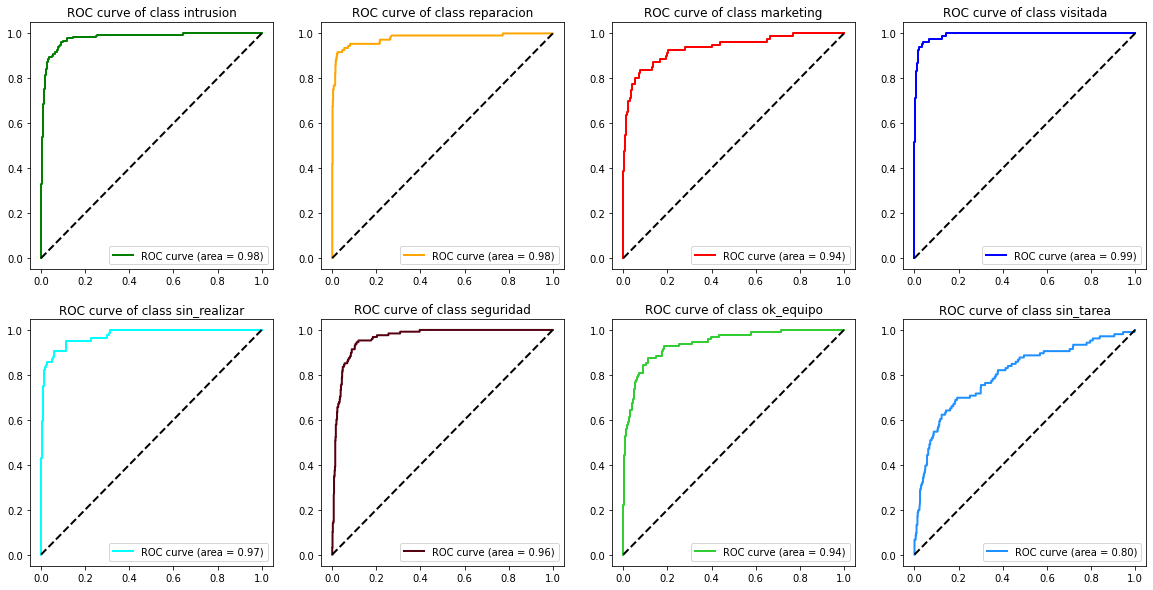

In [149]:
fig, axs = plt.subplots(2, 4, figsize = (20,10))

for i in range(n_classes):
    axs[int(i > 3), i%4].plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=2,
        label="ROC curve (area = {0:0.2f})".format(roc_auc[i])
    )
    axs[int(i > 3), i%4].plot([0, 1], [0, 1], "k--", lw=2)
    axs[int(i > 3), i%4].set_title("ROC curve of class {0}".format(id_a_clase[i]))
    axs[int(i > 3), i%4].legend(loc="lower right")


plt.show()

In [150]:
## Probabilidades con CalibratedClassifier

## https://medium.com/@manoveg/multi-class-text-classification-with-probability-prediction-for-each-class-using-linearsvc-in-289189fbb100

## Interpretacion del modelo nlp

### https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4

### https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b

## Bayes

### https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [151]:
print(y_test[:10].to_list())
print(y_pred[:10])

[2, 6, 7, 6, 7, 6, 6, 5, 2, 4]
[2 6 3 6 7 3 6 5 2 4]


In [152]:
aux = df_a_procesar.loc[y_test[30:40].index.to_list()]
aux = aux.drop('nro_palabras', axis=1)
aux = aux.drop('texto_corregido', axis=1)
aux['id_predicho'] = y_pred[30:40]
aux.head(7)

,clase_original,texto_original,texto_etl,id_clase,id_predicho
2559,seguridad,medidor normal. se cambio pipeta y se coloco caja anti hurto.,medidor normal cambio pipeta coloco caja anti hurto,5,5
308,market,se normalizo rh directo en habitaculo cliente no posee el documento,normalizo rehabilitado directo habitaculo cliente no tiene documento,2,0
52,intrusion,"se verifico medidor monofasico sin precinto de carcasa y con el disco trabado,se procedio al cambio de medidor, tapa y termica",verifico medidor monofasico sin precinto carcasa con disco trabado procedio cambio medidor tapa termica,0,0
398,intrusion,"se corto directo de linea. se normalizo instalacion de cliente. se dejo medidor en uso, se verifico lindero y se cambio tapa",corto directo linea normalizo instalacion cliente dejo medidor uso verifico lindero cambio tapa,0,0
3661,visitada,ya realizada se tomo datos de medidor ya cambiado fotos en adjunto .,ya realizada tomo datos medidor ya cambiado foto adjunto,3,3
2259,seguridad,"realizo inspeccion y control in situ con un resultado de X,XX% de error. si coloco tapa y termica, no se encontro anomalias",realizo inspeccion control interno sitio con resultado error coloco tapa termica no encontro anomalia,5,5
2591,ok_equipo,(obs. form. acciones: se inspeccino med sin anomalia),observacion inspeccion medidor sin anomalia,6,6
